In [118]:
from urllib.request import urlopen
import json
import pandas as pd
from datetime import datetime
from os import listdir
from os.path import isfile, join
import time
import pickle
from matplotlib import pyplot as plt

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

In [120]:
floodData = pd.read_csv("taff-llandaff-north-community-western-avenue.csv")

In [121]:
# floodData

In [122]:
def loadJSONFromURL(url):
    with urlopen(url) as url:
        data = json.loads(url.read().decode())
        return data
def queryHistoryWeather(lat, lon, start, end):
    key = "8f2e87a3a4e66791364dacb87d553e4a"
    #http://history.openweathermap.org/data/2.5/history/city?lat=41.85&lon=-87.65&appid=8f2e87a3a4e66791364dacb87d553e4a&start=1369728000&end=1369789200
    #query = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid="+key
    query = "http://history.openweathermap.org/data/2.5/history/city?lat="+str(lat)+"&lon="+str(lon)+"&appid="+key+"&start="+str(start)+"&end="+str(end)
    print(query)
    data = loadJSONFromURL(query)
    return data

In [123]:
def strToSecond(date_time_str):
    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%dT%H-%M-%SZ')
    return (int(date_time_obj.timestamp()))
def dateStrToSecond(date_time_str):
    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d')
    return (int(date_time_obj.timestamp()))

def strToObj(date_time_str):
    data = datetime.strptime(date_time_str, '%Y-%m-%d')
    obj = {
        "year" : data.year,
        "month" : data.month,
        "day" : data.day,
        "obj" : data
    }
    return obj

def secondToObj(x):
    data = datetime.fromtimestamp(x)
    obj = {
        "year" : data.year,
        "month" : data.month,
        "day" : data.day,
        "hour" : data.hour,
        "minute" : data.minute,
        "second" : data.second,
        "string1" : str(data.year)+"-"+str(data.month)+"-"+str(data.day)+"T"+str(data.hour)+"-"+str(data.minute)+"-"+str(data.second)+"Z",
        "string2" : str(data.year)+"-"+str(data.month)+"-"+str(data.day)+" "+str(data.hour)+"-"+str(data.minute)+"-"+str(data.second),
        "date": data.strftime('%Y-%m-%d'),
        "obj" : data
    }
    return obj

def saveCheckPd(data, filename):
    data.to_pickle(filename)
    outputCheck = pd.read_pickle(filename)
    if data.shape == outputCheck.shape:
        print("---Check: Pass")
        return True
    print("---Check: Fail")
    return False

In [124]:
floodData["timestamp"] = floodData["date"].apply(lambda x : dateStrToSecond(x))

In [125]:
floodData = floodData[floodData["timestamp"] >dateStrToSecond("2020-09-18")]

In [126]:
# floodData

In [127]:
def pullWeatherOfTaff(startTimeStr):
    latTaff = 51.497302
    lonTaff = -3.209873
    # Location reference: https://riverlevels.uk/taff-llandaff-north-community-western-avenue

    # queryHistoricalWeather(51.497302,-3.209873,)

#     startTimeStr="2020-09-19"
    print(startTimeStr)
    startTime = strToSecond(startTimeStr+"T08-30-0Z")
    endTime = startTime + 3600
    histData = queryHistoryWeather(latTaff,lonTaff,startTime,endTime)
    print("Count:",histData["message"])
    histData = histData["list"]
    histDataPd = pd.json_normalize(histData)
    histDataPd["date"]=startTimeStr
    saveCheckPd(histDataPd,"TaffWeather/"+startTimeStr+".pkl")

In [128]:
def pullAllWeatherList():
    lsDate = list(floodData["date"])
    for di in range(201,len(lsDate)):
        pullWeatherOfTaff(lsDate[di])

In [129]:
# pullAllWeatherList()

In [130]:
# pd.read_pickle("TaffWeather/"+startTimeStr+".pkl")

In [131]:
def mergedAllDataFromFolder(dataPath):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    mdf = pd.DataFrame([])
    for fs in onlyfiles:
        dataItem = pd.read_pickle(dataPath+"/"+fs)
        if mdf.empty:
            mdf = dataItem
        else:
            mdf = pd.concat([mdf, dataItem])
    return mdf

In [132]:
weatherData = mergedAllDataFromFolder("TaffWeather")

In [133]:
weatherData = weatherData.fillna(0)

In [134]:
weatherData

,dt,weather,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,clouds.all,date,rain.1h,wind.gust
0,1603357200,"[{'id': 804, 'main': 'Clouds', 'description': ...",282.85,281.24,1008,93,282.04,283.15,3.10,300,90,2020-10-22,0.00,0.0
0,1622019600,"[{'id': 803, 'main': 'Clouds', 'description': ...",286.02,285.35,1016,76,284.82,287.04,5.14,270,75,2021-05-26,0.00,0.0
0,1616576400,"[{'id': 804, 'main': 'Clouds', 'description': ...",281.95,279.62,1020,93,281.48,282.15,4.12,270,90,2021-03-24,0.00,0.0
0,1623920400,"[{'id': 803, 'main': 'Clouds', 'description': ...",288.67,288.16,1011,72,288.15,289.15,4.63,300,75,2021-06-17,0.00,0.0
0,1618477200,"[{'id': 800, 'main': 'Clear', 'description': '...",280.13,276.90,1034,65,279.82,280.37,5.14,90,7,2021-04-15,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1603098000,"[{'id': 803, 'main': 'Clouds', 'description': ...",283.33,282.83,1015,93,282.59,284.15,5.10,130,75,2020-10-19,0.00,0.0
0,1609491600,"[{'id': 804, 'main': 'Clouds', 'description': ...",273.51,270.99,1012,80,272.59,274.15,2.10,10,90,2021-01-01,0.00,0.0
0,1620810000,"[{'id': 801, 'main': 'Clouds', 'description': ...",284.67,283.86,1008,76,282.59,285.93,4.12,240,20,2021-05-12,0.00,0.0
0,1606554000,"[{'id': 804, 'main': 'Clouds', 'description': ...",279.65,275.87,1015,100,279.15,280.37,6.20,70,90,2020-11-28,0.00,0.0


In [135]:
mergedData = pd.merge(floodData,weatherData,on="date")

In [136]:
mergedData["year"] = mergedData["date"].apply(lambda x : strToObj(x)["year"])
mergedData["month"] = mergedData["date"].apply(lambda x : strToObj(x)["month"])
mergedData["day"] = mergedData["date"].apply(lambda x : strToObj(x)["day"])

In [137]:
# mergedData["dateTimeFTimeStamp"] = mergedData["dt"].apply(lambda x: secondToObj(x)["date"])

In [138]:
mergedData = mergedData.drop("min_level", axis=1).drop("max_level", axis=1)
mergedData = mergedData.drop("timestamp", axis=1).drop("dt", axis=1)
mergedData = mergedData.drop("weather", axis=1)

In [139]:
mergedData["next_day_level"] = mergedData["avg_level"].shift(periods=-1, fill_value=0.440)

In [140]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [141]:
mergedData

,date,avg_level,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,clouds.all,rain.1h,wind.gust,year,month,day,next_day_level
0,2020-09-19,0.597,287.59,287.23,1018,82,286.48,288.71,8.20,50,100,0.0,0.00,2020,9,19,0.592
1,2020-09-20,0.592,288.62,288.23,1019,77,288.15,289.26,7.70,50,11,0.0,0.00,2020,9,20,0.592
2,2020-09-21,0.592,287.05,286.64,1019,82,285.93,288.15,3.60,70,0,0.0,0.00,2020,9,21,0.589
3,2020-09-22,0.589,288.00,288.15,1011,100,287.59,288.15,2.10,300,75,0.0,0.00,2020,9,22,0.647
4,2020-09-23,0.647,287.05,287.11,1000,100,286.48,287.59,5.10,250,100,0.0,0.00,2020,9,23,0.907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2021-09-11,0.464,290.76,290.90,1016,89,289.36,292.49,1.79,229,20,0.0,4.92,2021,9,11,0.425
358,2021-09-12,0.425,290.36,290.20,1019,79,287.44,292.02,0.45,208,98,0.0,0.89,2021,9,12,0.410
359,2021-09-13,0.410,289.41,289.34,1017,86,288.35,290.36,0.45,336,75,0.0,1.79,2021,9,13,0.460
360,2021-09-14,0.460,288.92,288.98,1011,93,287.24,289.77,4.63,50,75,0.0,0.00,2021,9,14,0.424


In [142]:
mergedDataWithDate = mergedData.copy()
mergedData = mergedData.drop("date", axis=1)

In [143]:
# # !pip3 install seaborn
# import seaborn as sn
# from matplotlib import pyplot as plt

In [144]:
mergedDataWithDate = mergedDataWithDate.set_index('date')

In [145]:
# plt.figure(figsize=(20,20))
# plt.plot(mergedDataWithDate["max_level"])

In [146]:
# plt.figure(figsize=(20,20))
# sn.heatmap(mergedData.corr(), annot=True, fmt='.2f')

# XGBoost

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [148]:
import xgboost
modelXGBoost = xgboost.XGBRegressor(n_estimators=1000, max_depth=8, subsample=0.6, colsample_bytree=0.9,objective='reg:squarederror')


In [149]:
def splitDataSetSKLearn(datasetnorms, testSplitPercent):
    dataAllX = datasetnorms.drop("predict", axis=1)
    dataAllY = datasetnorms["predict"]
    X_train, X_test, y_train, y_test = train_test_split(dataAllX, dataAllY, test_size=testSplitPercent)
    return (dataAllX,dataAllY,X_train,y_train,X_test,y_test)

In [150]:
dfData = mergedData.copy()
dfData = dfData.rename(columns={"next_day_level":"predict"})
# (dataAllX,dataAllY,X_train,y_train,X_test,y_test) = splitDataSetSKLearn(dfData,0.2)

In [151]:
scaler = MaxAbsScaler()
scaledData = scaler.fit_transform(dfData)
dfDataNorm = pd.DataFrame(scaledData, columns=dfData.columns)
(dataAllX,dataAllY,X_train,y_train,X_test,y_test) = splitDataSetSKLearn(dfDataNorm,0.2)

In [152]:
start_time = time.time()
modelXGBoost.fit(X_train.to_numpy(), y_train.to_numpy())
print("XGBoost Training Time:",(time.time() - start_time))

XGBoost Training Time: 0.2758162021636963


In [153]:
start_time = time.time()
y_pred = modelXGBoost.predict(X_test.to_numpy())
print("XGBoost Prediction Time:",(time.time() - start_time))
# print("Accuracy score:",accuracy_score(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred, squared=True)
mape = mean_absolute_percentage_error(y_test, y_pred)

XGBoost Prediction Time: 0.007138252258300781


In [154]:
print("XGBoost Mean square error:",mse)
print("XGBoost mean absolute percentage error:",mape)

XGBoost Mean square error: 0.005133025363344238
XGBoost mean absolute percentage error: 0.16162242639155647


In [155]:
# y_true_1 = [3, 0.0, 2, 7]
# y_pred_1 = [2.5, -0.3, 2, 8]
# mean_absolute_percentage_error(y_pred_1,y_true_1)

In [156]:
# modelXGBoost.save_model('xgboost-model.json')
# modelXGBoost = xgboost.XGBRegressor()
# modelXGBoost.load_model('xgboost-model.json')

In [157]:
# y_true = [3]
# y_pred = [2.5]
# mean_absolute_percentage_error(y_true, y_pred)

In [235]:
featureList = list(dfData.columns.values)
# featureList

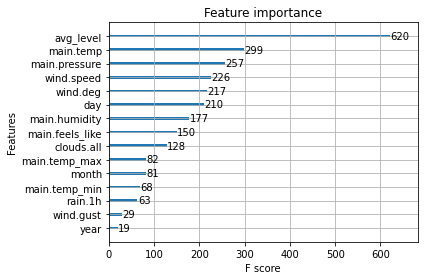

In [159]:
modelXGBoost.get_booster().feature_names = featureList
ax = xgboost.plot_importance(modelXGBoost.get_booster())
ax.figure.tight_layout()
ax.figure.savefig('xgboost-FeatureImportant.png')

In [160]:
# fig, ax = plt.subplots(figsize=(30, 30))
# xgboost.plot_tree(model, num_trees=10, ax=ax)
# plt.show()
# fig, ax = plt.subplots(figsize=(30, 30))
# xgboost.plot_tree(modelXGBoost, num_trees=0, ax=ax)
# # plt.show()
# plt.savefig('xgboost-tree.png', dpi=800, bbox_inches='tight')

# XGBoost K Fold

In [161]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

In [162]:
dfData = mergedData.copy()
dfData = dfData.rename(columns={"next_day_level":"predict"})
dataAllX = dfData.drop("predict", axis=1)
dataAllY = dfData["predict"]

In [46]:
# modelXGBoost = xgboost.XGBRegressor()
modelXGBoost = xgboost.XGBRegressor(n_estimators=1000, max_depth=8, subsample=0.6, colsample_bytree=0.9,objective='reg:squarederror')


In [47]:
# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(modelXGBoost, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

In [48]:
# kf_cv_scores

In [49]:
# score = modelXGBoost.score(X_train, y_train)  
# print("Training score: ", score)

In [50]:
start_time = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresXGBoost = cross_val_score(modelXGBoost, dataAllX, dataAllY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
print("XGBoost Training Time:",(time.time() - start_time))
timeXGBoost = time.time() - start_time

XGBoost Training Time: 1028.5890550613403


In [51]:
# start_time = time.time()
# y_pred = modelXGBoost.predict(X_test.to_numpy())
# print("XGBoost Prediction Time:",(time.time() - start_time))
# # print("Accuracy score:",accuracy_score(y_test, y_pred))
# mse = mean_squared_error(y_test, y_pred, squared=True)
# mape = mean_absolute_percentage_error(y_test, y_pred)

In [52]:
scoresXGBoost = absolute(scoresXGBoost)
print('Mean MSE: %.3f (%.3f)' % (scoresXGBoost.mean(), scoresXGBoost.std()) )
scoresXGBoostMean = scoresXGBoost.mean()

Mean MSE: 0.072 (0.031)


In [53]:
# model.save_model('xgboost-model.json')

# SVM

In [54]:
from sklearn import svm
# modelSVM = svm.SVR(kernel='poly', C=200, gamma='auto', degree=3, epsilon=0.1,coef0=1)
modelSVM = svm.SVR(kernel='poly')

In [55]:
# y_train.isnull().values.any()

In [56]:
start_time = time.time()
modelSVM.fit(X_train.to_numpy(), y_train.to_numpy())
print("SVM Training Time:",(time.time() - start_time))

SVM Training Time: 0.013785362243652344


In [57]:
start_time = time.time()
y_pred = modelSVM.predict(X_test.to_numpy())
print("SVM Prediction Time:",(time.time() - start_time))
mse = mean_squared_error(y_test, y_pred, squared=True)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("SVM score MSE:",mse)
print("SVM Score MAPE:",mape)

SVM Prediction Time: 0.0010936260223388672
SVM score MSE: 0.00819379933462465
SVM Score MAPE: 0.30457264619106356


In [58]:
pickle.dump(modelSVM, open("SVM-model", 'wb'))

In [59]:
pdX=pd.DataFrame(y_pred).reset_index()["index"].to_list()

In [60]:
pdYTest=pd.DataFrame(y_test)["predict"].to_list()

In [61]:
pd_y_pred=pd.DataFrame(y_pred).reset_index().to_numpy()

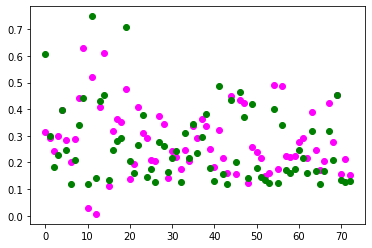

In [62]:
plt.scatter(pdX,y_pred, color = 'magenta')
plt.scatter(pdX,pdYTest, color = 'green')

# plt.plot(X, regressor.predict(X), color = 'green')
# plt.title('Truth or Bluff (Support Vector Regression Model)')
# plt.xlabel('Position level')
# plt.ylabel('Salary')
plt.show()

In [63]:
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()

# featureList = list(dfData.columns.values)
# f_importances(modelSVM.coef_, featureList)

## SVM K Fold

In [64]:
modelSVM = svm.SVR(kernel='poly')

In [65]:
start_time = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresSVM = cross_val_score(modelSVM, dataAllX, dataAllY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
print("SVM Training Time:",(time.time() - start_time))
timeSVM = time.time() - start_time

SVM Training Time: 0.15542268753051758


In [66]:
scoresSVM = absolute(scoresSVM)
print('Mean SVM MAE: %.3f (%.3f)' % (scoresSVM.mean(), scoresSVM.std()) )
scoresSVMMean = scoresSVM.mean()

Mean SVM MAE: 0.211 (0.097)


# Linear Regression

In [201]:
from sklearn.linear_model import LinearRegression
start_time = time.time()
modelLR = LinearRegression().fit(X_train.to_numpy(), y_train.to_numpy())
print("LR Training Time:",(time.time() - start_time))

LR Training Time: 0.0017197132110595703


In [202]:
start_time = time.time()
y_pred = modelLR.predict(X_test.to_numpy())
print("LR Prediction Time:",(time.time() - start_time))
mse = mean_squared_error(y_test, y_pred, squared=True)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("LR score MSE:",mse)
print("LR Score MAPE:",mape)

LR Prediction Time: 0.0004119873046875
LR score MSE: 0.00601162003435569
LR Score MAPE: 0.1632362034299899


In [203]:
modelLR.coef_

array([ 7.16076459e-01,  2.79997965e+00,  7.12473121e-01, -9.35212189e-02,
        1.07251592e-01,  7.84583395e-01, -4.36159598e+00,  1.46364309e-02,
        3.67544555e-02,  9.83622423e-03, -6.44417402e-02,  5.73875628e-02,
       -9.96192728e+01, -4.91892764e-02, -5.53595275e-03])

In [204]:
pd.DataFrame(zip(featureList,modelLR.coef_))

,0,1
0,avg_level,0.716076
1,main.temp,2.799980
2,main.feels_like,0.712473
3,main.pressure,-0.093521
4,main.humidity,0.107252
5,main.temp_min,0.784583
6,main.temp_max,-4.361596
7,wind.speed,0.014636
8,wind.deg,0.036754
9,clouds.all,0.009836


# Linear Regression Fold

In [190]:
modelLR = LinearRegression()

In [191]:
start_time = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresLR = cross_val_score(modelLR, dataAllX, dataAllY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
print("LR Training Time:",(time.time() - start_time))
timeLR = time.time() - start_time

LR Training Time: 0.1314866542816162


In [192]:
scoresLR = absolute(scoresLR)
print('Mean Ridge MSE: %.3f (%.3f)' % (scoresLR.mean(), scoresLR.std()) )
scoresLRMean = scoresLR.mean()

Mean Ridge MSE: 0.077 (0.037)


# Ridge

In [113]:
from sklearn.kernel_ridge import KernelRidge

In [114]:
modelKRR = KernelRidge(kernel='poly')
start_time = time.time()
modelKRR.fit(X_train.to_numpy(), y_train.to_numpy())
print("KRR Training Time:",(time.time() - start_time))

KRR Training Time: 0.04164862632751465


In [166]:
start_time = time.time()
y_pred = modelKRR.predict(X_test.to_numpy())
print("KRR Prediction Time:",(time.time() - start_time))
mse = mean_squared_error(y_test, y_pred, squared=True)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("KRR score MSE:",mse)
print("KRR Score MAPE:",mape)

KRR Prediction Time: 0.00838017463684082
KRR score MSE: 0.006193085266031506
KRR Score MAPE: 0.1922612460208065


In [70]:
# modelKRR.dual_coef_
from sklearn.model_selection import learning_curve
import numpy as np

# Ridge Fold

In [71]:
modelKRR = KernelRidge(kernel='poly')

In [164]:
start_time = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresRidge = cross_val_score(modelKRR, dataAllX, dataAllY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
print("KRR Training Time:",(time.time() - start_time))
timeRidge = time.time() - start_time

KRR Training Time: 2.0126113891601562


In [165]:
scoresRidge = absolute(scoresRidge)
print('Mean Ridge MSE: %.3f (%.3f)' % (scoresRidge.mean(), scoresRidge.std()) )
scoresRidgeMean = scoresRidge.mean()

Mean Ridge MSE: 2.510 (2.871)


# Decision Tree

In [205]:
from sklearn.tree import DecisionTreeRegressor

In [264]:
modelDT = DecisionTreeRegressor(random_state=2,max_depth=8)
start_time = time.time()
modelDT.fit(X_train.to_numpy(), y_train.to_numpy())
print("DT Training Time:",(time.time() - start_time))
timeDT = time.time() - start_time

DT Training Time: 0.0033605098724365234


In [253]:
featureListNoPredict = list(dfData.columns.values)
featureListNoPredict.remove("predict")

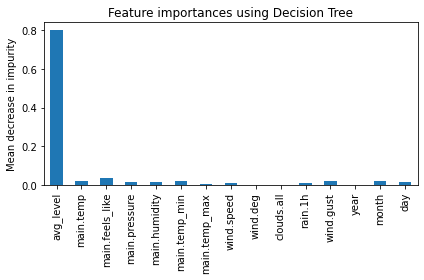

In [254]:
forest_importances = pd.Series(modelDT.feature_importances_, index=featureListNoPredict)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using Decision Tree")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# forest_importances

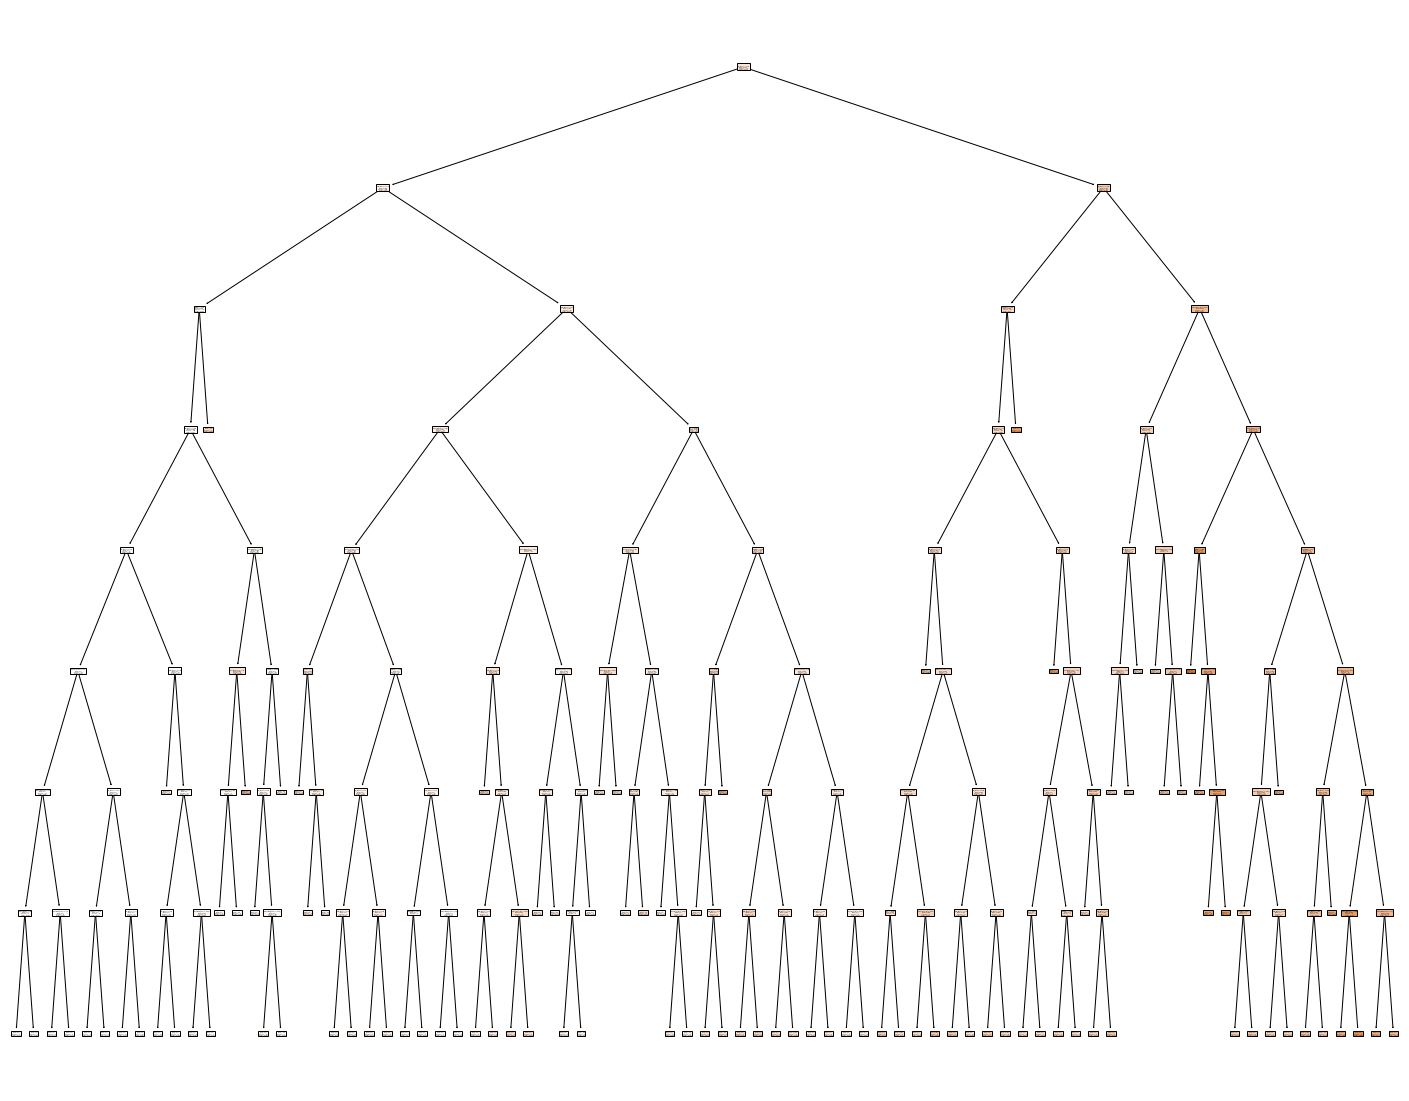

In [265]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelDT, 
                   feature_names=featureListNoPredict,  
                   filled=True)

In [207]:
start_time = time.time()
y_pred = modelDT.predict(X_test.to_numpy())
print("DT Prediction Time:",(time.time() - start_time))
mse = mean_squared_error(y_test, y_pred, squared=True)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("DT score MSE:",mse)
print("DT Score MAPE:",mape)

DT Prediction Time: 0.000993967056274414
DT score MSE: 0.012001578370887027
DT Score MAPE: 0.18116190205873933


In [208]:
# modelKRR.dual_coef_
from sklearn.model_selection import learning_curve
import numpy as np

# Tree Fold

In [255]:
modelDT = DecisionTreeRegressor(random_state=2,max_depth=8)

In [256]:
start_time = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresDT = cross_val_score(modelDT, dataAllX, dataAllY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
print("DT Training Time:",(time.time() - start_time))
timeRidge = time.time() - start_time

DT Training Time: 1.3755488395690918


In [258]:
scoresDT = absolute(scoresDT)
print('Mean DT MSE: %.3f (%.3f)' % (scoresDT.mean(), scoresRidge.std()) )
scoresDTMean = scoresDT.mean()

Mean DT MSE: 0.114 (2.871)


# KNN Regressor

In [74]:
from sklearn.neighbors import KNeighborsRegressor

In [75]:
modelKNN = KNeighborsRegressor(n_neighbors=2)

In [76]:
start_time = time.time()
modelKNN.fit(X_train.to_numpy(), y_train.to_numpy())
print("KNN Training Time:",(time.time() - start_time))

KNN Training Time: 0.00139617919921875


In [77]:
start_time = time.time()
y_pred = modelKNN.predict(X_test.to_numpy())
print("KNN Prediction Time:",(time.time() - start_time))
mse = mean_squared_error(y_test, y_pred, squared=True)
mape = mean_absolute_percentage_error(y_test, y_pred)

KNN Prediction Time: 0.0018253326416015625


In [78]:
print("KNN score MSE:",mse)
print("KNN Score MAPE:",mape)

KNN score MSE: 0.010215528558073315
KNN Score MAPE: 0.20713950149011856


In [79]:
pickle.dump(modelKNN, open("KNN-model", 'wb'))

In [80]:
# modelKNN = KNeighborsRegressor(n_neighbors=2)
# modelKNN = pickle.load(open("KNN-model", 'rb'))
# y_pred = modelKNN.predict(X_test.to_numpy())
# mse = mean_squared_error(y_test, y_pred, squared=True)
# mse

# KNN K-Fold

In [81]:
modelKNN = KNeighborsRegressor(n_neighbors=2)

In [82]:
start_time = time.time()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scoresKNN = cross_val_score(modelKNN, dataAllX, dataAllY, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
print("KNN Training Time:",(time.time() - start_time))
timeKNN = time.time() - start_time

KNN Training Time: 0.12288117408752441


In [83]:
scoresKNN = absolute(scoresKNN)
print('Mean KNN MAE: %.3f (%.3f)' % (scoresKNN.mean(), scoresKNN.std()) )
scoresKNNMean = scoresKNN.mean()

Mean KNN MAE: 0.190 (0.089)


# ANN

In [84]:
# !pip3 install tensorflow
# !pip3 install keras

In [85]:
# dfData

In [86]:
# abs_scaler = MaxAbsScaler()
# # X_train,y_train,X_test,y_test
# X_train_ann = abs_scaler.fit_transform(X_train)
# X_test_ann = abs_scaler.transform(X_test)
# y_train_ann = abs_scaler.fit_transform(y_train)
# y_test_ann = abs_scaler.transform(y_test)
# scaler = MaxAbsScaler()
# scaledData = scaler.fit_transform(dfData)
# dfDataNorm = pd.DataFrame(scaledData, columns=dfData.columns)
# (dataAllX,dataAllY,X_train,y_train,X_test,y_test) = splitDataSetSKLearn(dfDataNorm,0.2)

In [87]:
scalerfile = 'ann-scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# import pickle
# scalerfile = 'ann-scaler.sav'
# scaler = pickle.load(open(scalerfile, 'rb'))
# test_scaled_set = scaler.transform(test_set)

In [88]:
# X_train

In [89]:
X_train_ann = X_train.to_numpy().reshape((X_train.shape[0],X_train.shape[1],1))
X_test_ann = X_test.to_numpy().reshape((X_test.shape[0],X_test.shape[1],1))
Y_train_ann = y_train.to_numpy().reshape((X_train.shape[0],1))
Y_test_ann = y_test.to_numpy().reshape((y_test.shape[0],1))
print("Data Shape:",X_train_ann.shape," ",Y_train_ann.shape)

Data Shape: (289, 15, 1)   (289, 1)


In [90]:
modelANN = keras.Sequential()
modelANN.add(Dense(units=10,input_shape=(X_train_ann.shape[1],X_train_ann.shape[2]),activation='relu'))  
modelANN.add(Dense(units=4,activation='relu')) 
modelANN.add(keras.layers.Flatten())
modelANN.add(Dense(units=1)) #output layer   

In [91]:
modelANN.summary()
# keras.utils.plot_model(model, "ann.png", show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15, 10)            20        
_________________________________________________________________
dense_1 (Dense)              (None, 15, 4)             44        
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


In [92]:
# !pip3 install pydot

In [93]:
# from keras.utils import plot_model
# keras.utils.plot_model(modelANN, to_file='ann.png')

In [94]:
# model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])
start_time = time.time()

modelANN.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

history = modelANN.fit(X_train_ann, Y_train_ann, epochs=200, validation_split = 0.2)

print("ANN Training Time:",(time.time() - start_time))

Epoch 1/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 7/200
8/8 [============================

In [95]:
print(history.history.keys())


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


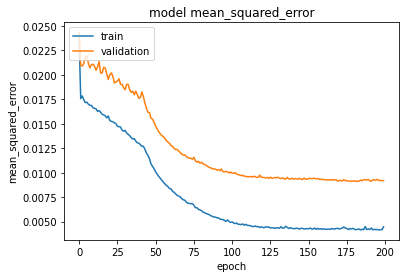

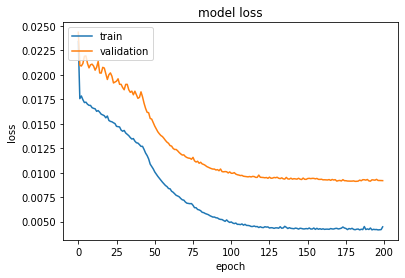

In [96]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [97]:
# X_test.shape

In [98]:
y_pred = modelANN.predict(X_test_ann)
# # print("Accuracy score:",accuracy_score(y_test, y_pred))
# y_pred
mse = mean_squared_error(y_test, y_pred, squared=True)
mae = mean_absolute_percentage_error(y_test, y_pred)

In [99]:
print("ANN Mean square error:",mse)
print("ANN mean absolute percentage error:",mae)

ANN Mean square error: 0.006989777408316581
ANN mean absolute percentage error: 0.1787794069745792


In [100]:
modelANN.save('ann.h5')
# modelANN = tf.keras.models.load_model('ann.h5')

# ANN K-Fold

In [101]:

dataAllX_ann = dataAllX.to_numpy().reshape((dataAllX.shape[0],dataAllX.shape[1],1))
dataAllY_ann = dataAllY.to_numpy().reshape((dataAllY.shape[0],1))

In [102]:
start_time = time.time()

kfold = KFold(n_splits=10, shuffle=True)
lsAnnMSE = []
for train, test in kfold.split(dataAllX_ann, dataAllY_ann):
    modelANN = keras.Sequential()
    modelANN.add(Dense(units=10,input_shape=(X_train_ann.shape[1],X_train_ann.shape[2]),activation='relu'))  
    modelANN.add(Dense(units=4,activation='relu')) 
    modelANN.add(keras.layers.Flatten())
    modelANN.add(Dense(units=1)) #output layer   
    # model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])
    modelANN.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

    history = modelANN.fit(X_train_ann, Y_train_ann, epochs=200, validation_split = 0.2)
    y_pred = modelANN.predict(X_test_ann)
    # # print("Accuracy score:",accuracy_score(y_test, y_pred))
    # y_pred
    mse = mean_squared_error(y_test, y_pred, squared=True)
    mae = mean_absolute_percentage_error(y_test, y_pred)
    print("XGBoost Mean square error:",mse)
    print("XGBoost mean absolute percentage error:",mae)
    lsAnnMSE.append(mse)
    
print("ANN Training Time:",(time.time() - start_time))
timeANN = time.time() - start_time

Epoch 1/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 7/200
8/8 [============================

In [103]:
import numpy as np
lsAnnMSE = np.array(lsAnnMSE)
print('Mean ANN MAE: %.3f (%.3f)' % (lsAnnMSE.mean(), lsAnnMSE.std()) )
scoresANNMean = lsAnnMSE.mean()

Mean ANN MAE: 0.007 (0.000)


In [198]:
# lsAnnMSE

# Comparision

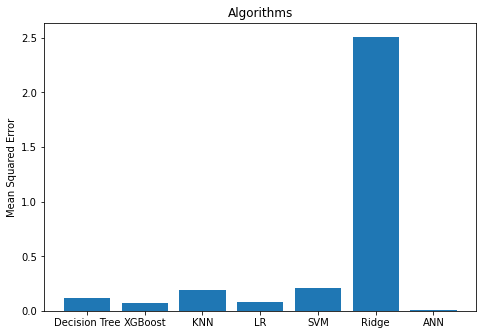

In [262]:
# cpd = pd.DataFrame([])
algorithm =  ["Decision Tree","XGBoost", "KNN","LR","SVM","Ridge","ANN"]
mseList = [scoresDTMean, scoresXGBoostMean, scoresKNNMean, scoresLRMean, scoresSVMMean, scoresRidgeMean, scoresANNMean]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(algorithm, mseList)
plt.ylabel("Mean Squared Error")
plt.title('Algorithms')
plt.show()



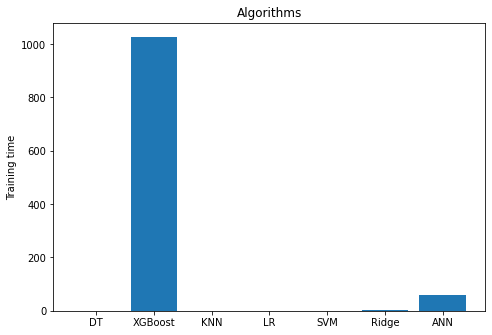

In [259]:
# cpd = pd.DataFrame([])
algorithm =  ["DT","XGBoost", "KNN","LR","SVM","Ridge","ANN"]
mseList = [timeDT,timeXGBoost, timeKNN,timeLR, timeSVM,timeRidge,timeANN]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(algorithm, mseList)
plt.ylabel("Training time")
plt.title('Algorithms')
plt.show()



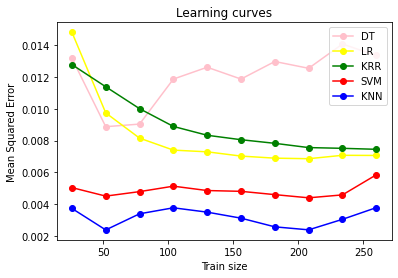

In [260]:
train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(modelDT, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(modelLR, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

train_sizes_krr, train_scores_krr, test_scores_krr = learning_curve(modelKRR, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(modelSVM, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

train_sizes_knn, train_scores_knn, test_scores_knn = learning_curve(modelKNN, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

#train_sizes_ann, train_scores_ann, test_scores_ann = learning_curve(modelANN, X_train.to_numpy(), y_train.to_numpy(), train_sizes=np.linspace(0.1, 1, 10),
#                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes_dt, -test_scores_dt.mean(1), 'o-', color="pink", label="DT")
plt.plot(train_sizes_lr, -test_scores_lr.mean(1), 'o-', color="yellow", label="LR")
plt.plot(train_sizes_krr, -test_scores_krr.mean(1), 'o-', color="green", label="KRR")
plt.plot(train_sizes_svm, -train_scores_svm.mean(1), 'o-', color="red", label="SVM")
plt.plot(train_sizes_knn, -train_scores_knn.mean(1), 'o-', color="blue", label="KNN")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

# Backup

In [268]:
!rm river-production.tar.gz
!tar -czvf river-production.tar.gz .

./
./xgboost-mea.png
./ann.h5
./Taff-LoadWeatherData.ipynb
./xgboost-FeatureImportant.png
./FrontEnd/
./FrontEnd/public/
./FrontEnd/public/font/
./FrontEnd/public/font/unicons.svg
./FrontEnd/public/font/unicons.woff
./FrontEnd/public/font/unicons.eot
./FrontEnd/public/font/unicons.woff2
./FrontEnd/public/font/unicons.ttf
./FrontEnd/public/.ipynb_checkpoints/
./FrontEnd/public/Template/
./FrontEnd/public/Template/MainPage.html
./FrontEnd/public/Template/PageStyle.css
./FrontEnd/public/Template/JSPage.js
./FrontEnd/public/js/
./FrontEnd/public/js/popper.min.js
./FrontEnd/public/js/reportor.js
./FrontEnd/public/js/smoothscroll.js
./FrontEnd/public/js/Headroom.js
./FrontEnd/public/js/jquery-3.3.1.min.js
./FrontEnd/public/js/custom.js
./FrontEnd/public/js/owl.carousel.min.js
./FrontEnd/public/js/jQuery.headroom.js
./FrontEnd/public/js/bootstrap.min.js
./FrontEnd/public/images/
./FrontEnd/public/images/project/
./FrontEnd/public/images/project/project-image02.png
./FrontEnd/public/images/pro